# BOOSTDM CROSS VALIDATION

Generate random cross validation data:

1. Version 1 - training mutations are removed from CV test set
2. Version 2 - NO-eliminating repeated mutations
3. Presition Recall plots


In [6]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import glob
import gzip
import pickle
import pandas as pd

pd.set_option('display.max_rows', 10)

In [12]:
# Upload different outputs from BoostDM-CH
basepath = '../../Paper_data/BoostDM-CH/'
cvsplit_folder = os.path.join(basepath, 'splitcv_meta')  # cross-validation split folders
models_folder = os.path.join(basepath, 'training_meta', 'CH')  # models folder
modeleval_folder = os.path.join(basepath, 'evaluation')  # cross-validation scores after training


### Get list of 12 genes with high quality models F>0.8
genes12 = ['ASXL1', 'CHEK2', 'DNMT3A', 'GNAS', 'IDH2', 'MDM4', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']
print(genes12)

['ASXL1', 'CHEK2', 'DNMT3A', 'GNAS', 'IDH2', 'MDM4', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']


# Generate random cross validation data

In [9]:
def parse_cv(gene):
    
    cv_list = []
    fn = os.path.join(cvsplit_folder, 'CH', f'{gene}.cvdata.pickle.gz')
    with gzip.open(fn, 'rb') as f:
        l = pickle.load(f)
    return l


def load_models(path):
    
    with gzip.open(path, 'rb') as g:
        models = pickle.load(g)
    return models


def get_cv_prediction(gene):
        
    fn = os.path.join(models_folder, f'{gene}.models.pickle.gz')
    models = load_models(fn)
    splitcv = parse_cv(gene)
    
    res = []

    for i, split in enumerate(splitcv):
        
        train_features = split[0]
        test_features = split[1]
        
        # muts: mutations in the test set, excluding those that are already seen in the training set
        
        muts = test_features[
            ~test_features.apply(
                lambda x: (x['pos'], x['ref'], x['alt']), 
                axis=1
            ).isin(train_features.apply(lambda x: (x['pos'], x['ref'], x['alt']), axis=1))
        ]
        
        features = muts[[c for c in muts.columns if c not in ['chr', 'pos', 'ref', 'alt']]]
        coords = muts[['chr', 'pos', 'ref', 'alt']]
        
        y = split[3].loc[muts.index]  # true driver labels
        
        mod = models['models'][i]

        # prediction of i-th base model against muts
        yhat = mod.predict_proba(features)[:, 1]

        # put together features, genomic coordinates and true driver labels
        df = pd.concat([features, coords, y], axis=1)
                
        # add prediction with i-th base model
        df['boostDM_score'] = yhat
        df.rename(columns={'label': 'driver'}, inplace=True)
        
        res.append(df)

    return res


def get_cv_prediction_2(gene):
        
    fn = os.path.join(models_folder, f'{gene}.models.pickle.gz')
    models = load_models(fn)
    splitcv = parse_cv(gene)
    
    res = []

    for i, split in enumerate(splitcv):
        
        train_features = split[0]
        test_features = split[1]
        
        # muts: mutations in the test set NOT excluding those that are already seen in the training set
        
        muts = test_features.copy()
        
        features = muts[[c for c in muts.columns if c not in ['chr', 'pos', 'ref', 'alt']]]
        coords = muts[['chr', 'pos', 'ref', 'alt']]
        
        y = split[3].loc[muts.index]  # true driver labels
        
        mod = models['models'][i]

        # prediction of i-th base model against muts
        yhat = mod.predict_proba(features)[:, 1]

        # put together features, genomic coordinates and true driver labels
        df = pd.concat([features, coords, y], axis=1)
                
        # add prediction with i-th base model
        df['boostDM_score'] = yhat
        df.rename(columns={'label': 'driver'}, inplace=True)
        
        res.append(df)

    return res

In [11]:
# Example
import boostwrap

res = get_cv_prediction('ASXL1')
res[0]

,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,...,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,chr,pos,ref,alt,driver,boostDM_score
0,0.0,0,0,0,-0.177002,1,0.0,0.0,0.0,0.0,...,0,1,0,0,20,32434902,C,A,1,0.919798
2,0.0,0,0,0,2.931641,0,0.0,0.0,0.0,0.0,...,1,0,0,0,20,32434543,G,T,0,0.013096
4,0.0,0,0,0,2.238281,0,0.0,0.0,0.0,0.0,...,1,0,0,0,20,32435912,C,G,0,0.010253
6,0.0,0,0,0,-0.860840,1,0.0,0.0,0.0,0.0,...,0,1,0,0,20,32435795,C,A,1,0.919798
9,0.0,0,0,0,3.177734,0,0.0,0.0,0.0,0.0,...,0,1,0,0,20,32433327,C,T,1,0.974933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.0,0,0,0,4.343750,1,0.0,0.0,0.0,0.0,...,0,1,0,0,20,32436040,C,T,1,0.983082
68,0.0,0,0,0,-0.480957,1,0.0,0.0,0.0,0.0,...,0,1,0,0,20,32435428,G,T,1,0.919798
69,0.0,0,0,0,3.248047,0,0.0,0.0,0.0,0.0,...,1,0,0,0,20,32435227,G,T,0,0.012591
70,0.0,0,0,0,0.372070,0,0.0,0.0,0.0,0.0,...,0,0,0,1,20,32437053,C,T,0,0.019867


# 1. Version 1 - eliminating repeated mutations

In [15]:
for gene in genes12:
    # Get all model tables
    res = get_cv_prediction(gene)
    
    # Create table with the first iteration
    full_table = res[0]
    full_table = full_table.assign(iteration=0)

    for i in range(1,50):
        iteration = res[i].assign(iteration=i)
        full_table = pd.concat([full_table, iteration])
    
    full_table = full_table.reset_index(drop=True)
    # Save
    file_name = '../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/' + gene + '_crossvalidation_50iterations.txt'
    full_table.to_csv(file_name, sep='\t')

# 2. Version 2 - NO-eliminating repeated mutations

In [16]:
for gene in genes12:
    # Get all model tables
    res = get_cv_prediction_2(gene)
    
    # Create table with the first iteration
    full_table_2 = res[0]
    full_table_2 = full_table_2.assign(iteration=0)

    for i in range(1,50):
        iteration = res[i].assign(iteration=i)
        full_table_2 = pd.concat([full_table_2, iteration])
    
    full_table_2 = full_table_2.reset_index(drop=True)
    # Save
    file_name = '../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/' + gene + '_crossvalidation_50iterations_V2.txt'
    full_table_2.to_csv(file_name, sep='\t')

# 3. Precision-recall curves

# Version 1 - eliminating repeated mutations

In [17]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc


palette_boostdm = {'boostDM_score': '#ac0f0f', 'boostDM_score_strict': '#ad6f0f'}


# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, gene, ax=None, plot=True, **kwargs):
    
    df = df[(~df['boostDM_score'].isnull())]
    # X = df['boostDM_score'].values.reshape(-1, 1)
    X = df['boostDM_score'].values
    y = df['driver'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    
    # number of mutations
    # n = len(y)
    # positive = sum(y)
    # negative = n - positive
    
    # model.fit(X, y)
    # yhat = model.predict_proba(X)
    # probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{gene}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall

In [18]:
genes15_col = {
           'DNMT3A':'#023E8A',
           'TET2':'#48CAE4',
           'ASXL1':'#0096C7',
           'CHEK2':'#F8961E',
           'TP53':'#F94144',
           'PPM1D':'#F3722C',
           'MDM4':'#F9C74F',
           'SF3B1':'#90BE6D',
           'SRSF2':'#43AA8B',
           'U2AF1':'#4D908E',   
           'GNAS':'#7209B7',
           'IDH2':'#B5179E'      
           }

12it [00:00, 130.91it/s]


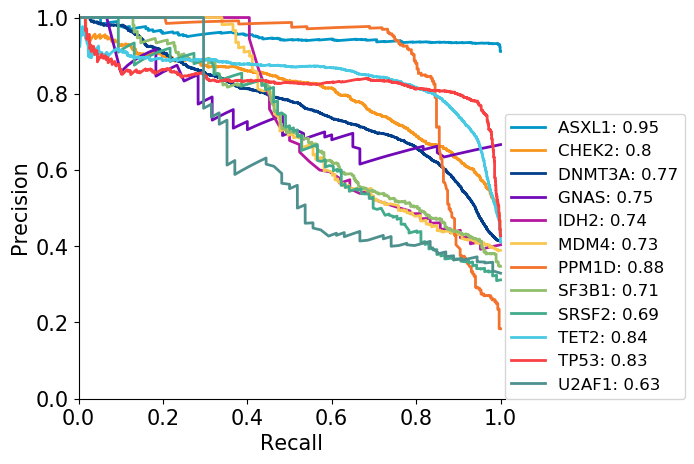

In [21]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'

cmap = cm.tab20
config_params(font_size=15)
fig, ax = plt.subplots(figsize=(5.5,5))
for i, gene in tqdm.tqdm(enumerate(genes12)):
    color = genes15_col[gene]
    fn = f'../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/{gene}_crossvalidation_50iterations.txt'
    df = pd.read_csv(fn, sep='\t')
    plot_prc(df, gene, ax=ax, color=color, lw=2, alpha=1)
plt.legend(loc=(1,0), fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(size=15)
plt.yticks(size=15)
# plt.xlabel(size=15)
# plt.ylabel(size=15)
plt.show()

12it [00:00, 43.69it/s]
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


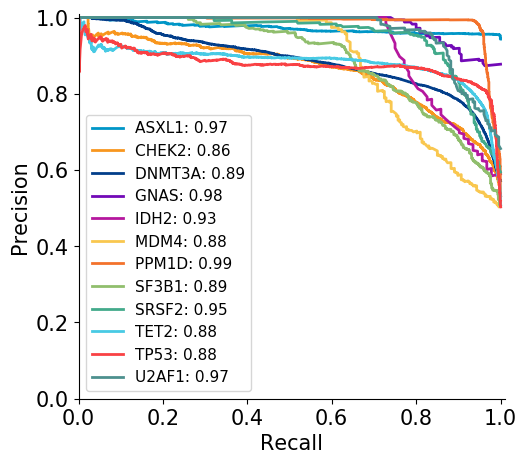

In [22]:
import matplotlib as mpl

def config_params(font_size=12):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
def get_mean(gene, ttype, variable):
    with gzip.open(os.path.join(OUTPUT, 
                            'evaluation', 
                            f'{ttype}', 
                            f'{gene}.eval.pickle.gz'), 'rb') as f:
        eval_d = pickle.load(f)
    return np.mean(eval_d[variable]), np.nanmean(eval_d[variable])

cmap = cm.tab20
config_params(font_size=15)
fig, ax = plt.subplots(figsize=(5.5,5))
for i, gene in tqdm.tqdm(enumerate(genes12)):
    color = genes15_col[gene]
    fn = f'../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/{gene}_crossvalidation_50iterations_V2.txt'
    df = pd.read_csv(fn, sep='\t')
    plot_prc(df, gene, ax=ax, color=color, lw=2, alpha=1)
    
plt.legend(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(size=15)
plt.yticks(size=15)
# plt.xlabel(size=15)
# plt.ylabel(size=15)

plt.show()